# Neural Networks
Content:
- **Linear Regression**
    - using sklearn
    - normal equation
    - as numerical optimization problem
    - as neural network
-  **Intuition behind Neural Networks**
-  **The universal approximation Theorem**

In [1]:
!pip install torch
!pip install numpy
!pip install pandas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets

### Linear Regression
- Todo unify shapes of coefficients to make smooth experience

In [3]:
def load_diabetes():
    x_columns = {'bp': 'bloodPressure', 
                 'bmi': 'bodyMassIndex',
                 's1': 'totalSerumCholesterol', 
                 's2': 'lowDensityLipoproteins',
                 's3': 'highDensityLipoproteins',
                 's4': 'totalCholesterol',
                 's5': 'serumTriglyceridesLevel',
                 's6': 'bloodSugarLevel'}
    x, y = datasets.load_diabetes(return_X_y=True, as_frame=True)
    x = x.rename(columns=x_columns)
    y = pd.DataFrame({'diseaseProgression': y})
    return x, y


def split_test_train(x, y):
    return 1/0


### Load Data and visualize
**Todo**: decide on data set

Text(0, 0.5, 'Disease Progression')

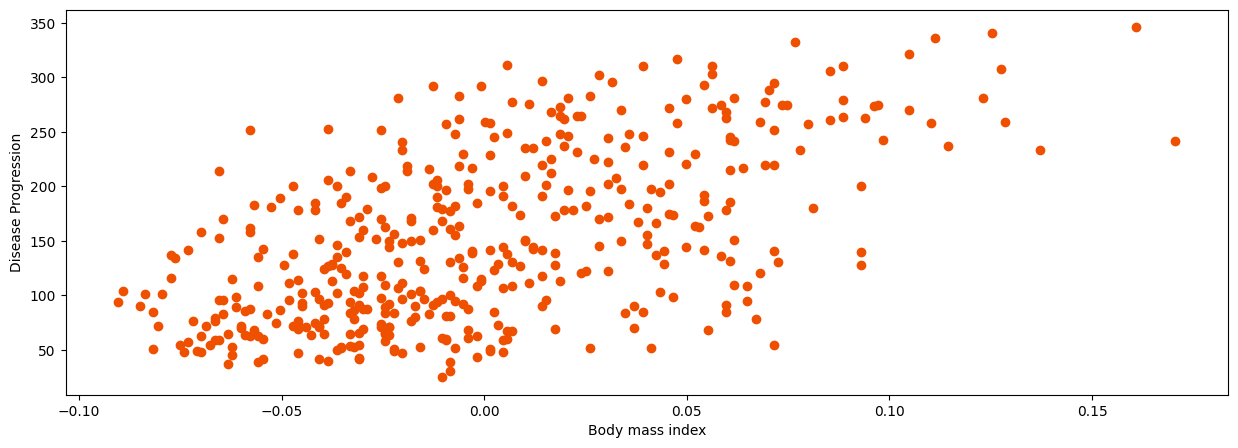

In [4]:
x, y = load_diabetes()

# Todo test train split
x_train, y_train = x, y
x_test, y_test = x, y

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')


# Linear Regression
### Linear Regression using Sklearn

In [5]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train[['bodyMassIndex']], y_train)
print(f"Intercept {regr.intercept_[0]}, Coefficient {regr.coef_[0,0]} ")
x_pred = x_test[['bodyMassIndex']].sort_values(by='bodyMassIndex')
y_pred = regr.predict(x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840388 


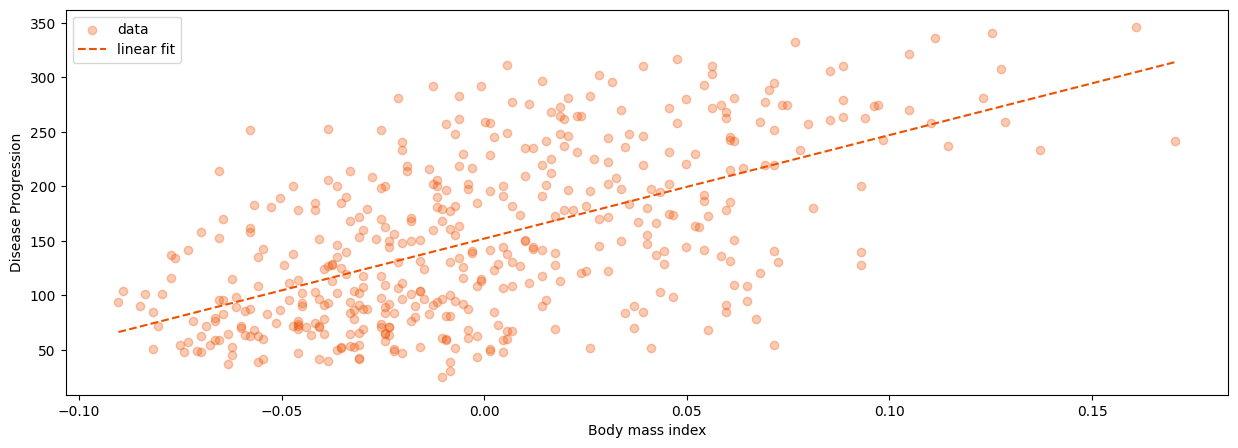

In [6]:

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred, y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()

### Linear Regression using the normal equation
The normal equation is a closed form solution of the linear regression problem. It gives the fit coefficients $\alpha$ in terms of matrix mulitplication.
Once the coefficients are calculated a prediction $\hat y$ can be made.

$$\alpha = (x^Tx)^{-1} x^T y$$
$$\hat y = \alpha^T x$$

In [7]:
def add_intercept(x):
    return x.assign(intercept = 1)
    
def fit_normal_equation(x, y):
    x_t = x.transpose()
    inverse = np.linalg.inv(x_t @ x)
    alpha = inverse @ x_t @ y
    return alpha

def predict_normal_equation(alpha, x):
    print (alpha.shape, x.shape)
    return x @ alpha
    

In [8]:
x_fit = add_intercept(x_train)[['intercept', 'bodyMassIndex']].values
y_fit = y_train.values
alpha = fit_normal_equation(x_fit, y_fit)
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")
x_pred = add_intercept(x_test)[['intercept', 'bodyMassIndex']].sort_values(by='bodyMassIndex').values
y_pred = predict_normal_equation(alpha, x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840387 
(2, 1) (442, 2)


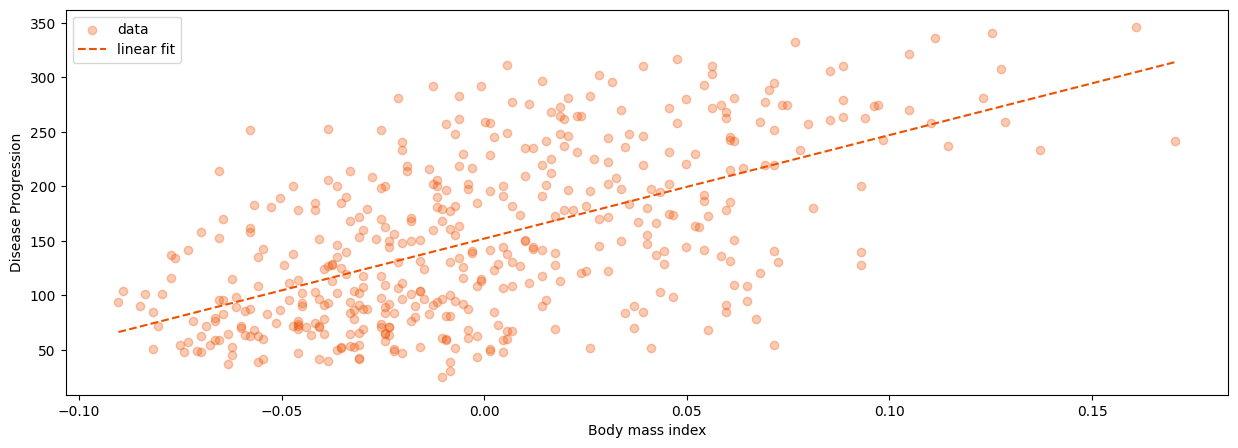

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred[:, 1], y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()


### Linear Regression as numerical optimization problem

In [10]:
from scipy import optimize

def reshape_alpha(alpha):
    return alpha[..., np.newaxis] 


def f(alpha):
    a = reshape_alpha(alpha)
    loss =  (x_fit @ a - y_fit)**2
    return loss.sum()

 
opt = optimize.minimize(f, np.array([0, 0]), method='nelder-mead')
alpha = reshape_alpha(opt['x'])
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")

Intercept 152.13348218121047, Coefficient 949.4352653323601 


### Linear Regression as Neural Network

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) 

    def forward(self, x):
        return self.linear(x)

In [12]:
model = LinearRegressionModel()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=0.5)  # Stochastic Gradient Descent

x_fit_torch = torch.from_numpy(x_train[['bodyMassIndex']].values).to(torch.float32)
y_fit_torch = torch.from_numpy(y_train[['diseaseProgression']].values).to(torch.float32)


# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass: compute prediction and loss
    y_pred = model(x_fit_torch)
    loss = criterion(y_pred, y_fit_torch)
    
    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f},  intercept: {model.linear.bias.data[0]}, Coefficient {model.linear.weight.data[0, 0]}')

Epoch 100/5000, Loss: 5194.4600,  intercept: 152.13348388671875, Coefficient 191.96290588378906
Epoch 200/5000, Loss: 4719.4336,  intercept: 152.13348388671875, Coefficient 345.48834228515625
Epoch 300/5000, Loss: 4417.4512,  intercept: 152.13348388671875, Coefficient 467.89715576171875
Epoch 400/5000, Loss: 4225.4771,  intercept: 152.13348388671875, Coefficient 565.4957275390625
Epoch 500/5000, Loss: 4103.4346,  intercept: 152.13348388671875, Coefficient 643.3131103515625
Epoch 600/5000, Loss: 4025.8503,  intercept: 152.13348388671875, Coefficient 705.3584594726562
Epoch 700/5000, Loss: 3976.5283,  intercept: 152.13348388671875, Coefficient 754.828369140625
Epoch 800/5000, Loss: 3945.1743,  intercept: 152.13348388671875, Coefficient 794.2715454101562
Epoch 900/5000, Loss: 3925.2412,  intercept: 152.13348388671875, Coefficient 825.7202758789062
Epoch 1000/5000, Loss: 3912.5696,  intercept: 152.13348388671875, Coefficient 850.7951049804688
Epoch 1100/5000, Loss: 3904.5146,  intercept: 1

# Intuition behind neural networks
- The learning goal is to understand a neural network 
    - as piecewise linear approximation (for relu activation). 
    - hidden layers correspond to 'parallel' linear regressions. 
Todo: scale / speed up convergence for other functions

In [13]:
x = torch.arange(1, 10, 0.001).reshape(-1, 1)
y =  50* x + ( 10 * x + x**2) * torch.sin(3*x) 

# Create data
x_train = np.linspace(-   0 * np.pi, 1 * np.pi, 1000).reshape(-1, 1)
y_train = np.sin(x_train)

# Convert data to torch tensors
x = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

In [14]:
class Foobar(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 2) 
        self.out = nn.Linear(2, 1)
        

    def forward(self, x):
        y = torch.relu(self.hidden(x))
        y = self.out(y)
        return y


model = Foobar()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.Adam(model.parameters(), lr=0.1)  # Stochastic Gradient Descent


# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass: compute prediction and loss
    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Print loss every 100 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')

Epoch 1000/50000, Loss: 0.00665423
Epoch 2000/50000, Loss: 0.00396883
Epoch 3000/50000, Loss: 0.00400865
Epoch 4000/50000, Loss: 0.00394961
Epoch 5000/50000, Loss: 0.00396576
Epoch 6000/50000, Loss: 0.00411284
Epoch 7000/50000, Loss: 0.00402282
Epoch 8000/50000, Loss: 0.00579224
Epoch 9000/50000, Loss: 0.00416615
Epoch 10000/50000, Loss: 0.00397816
Epoch 11000/50000, Loss: 0.00419591
Epoch 12000/50000, Loss: 0.00396580
Epoch 13000/50000, Loss: 0.00438416
Epoch 14000/50000, Loss: 0.00400539
Epoch 15000/50000, Loss: 0.00395339
Epoch 16000/50000, Loss: 0.00394947
Epoch 17000/50000, Loss: 0.00397587
Epoch 18000/50000, Loss: 0.00396499
Epoch 19000/50000, Loss: 0.00395308
Epoch 20000/50000, Loss: 0.00626665
Epoch 21000/50000, Loss: 0.00434627
Epoch 22000/50000, Loss: 0.00399588
Epoch 23000/50000, Loss: 0.00431894
Epoch 24000/50000, Loss: 0.00396973
Epoch 25000/50000, Loss: 0.00394994
Epoch 26000/50000, Loss: 0.00394895
Epoch 27000/50000, Loss: 0.00397321
Epoch 28000/50000, Loss: 0.00408509
E

In [15]:
with torch.no_grad():  # Disable gradient calculation for inference
    y_pred = model(x)
    hidden_components = model.hidden(x)
    bias = model.out.bias 
    weights = model.out.weight
    

In [16]:
y_1 = torch.matmul(hidden_components,  weights.data.T)
print(hidden_components.shape)
print(weights.data.T.shape)
hidden_components

torch.Size([1000, 2])
torch.Size([2, 1])


tensor([[ 2.5854,  2.9062],
        [ 2.5801,  2.9033],
        [ 2.5749,  2.9004],
        ...,
        [-2.6279,  0.0277],
        [-2.6332,  0.0248],
        [-2.6384,  0.0219]])

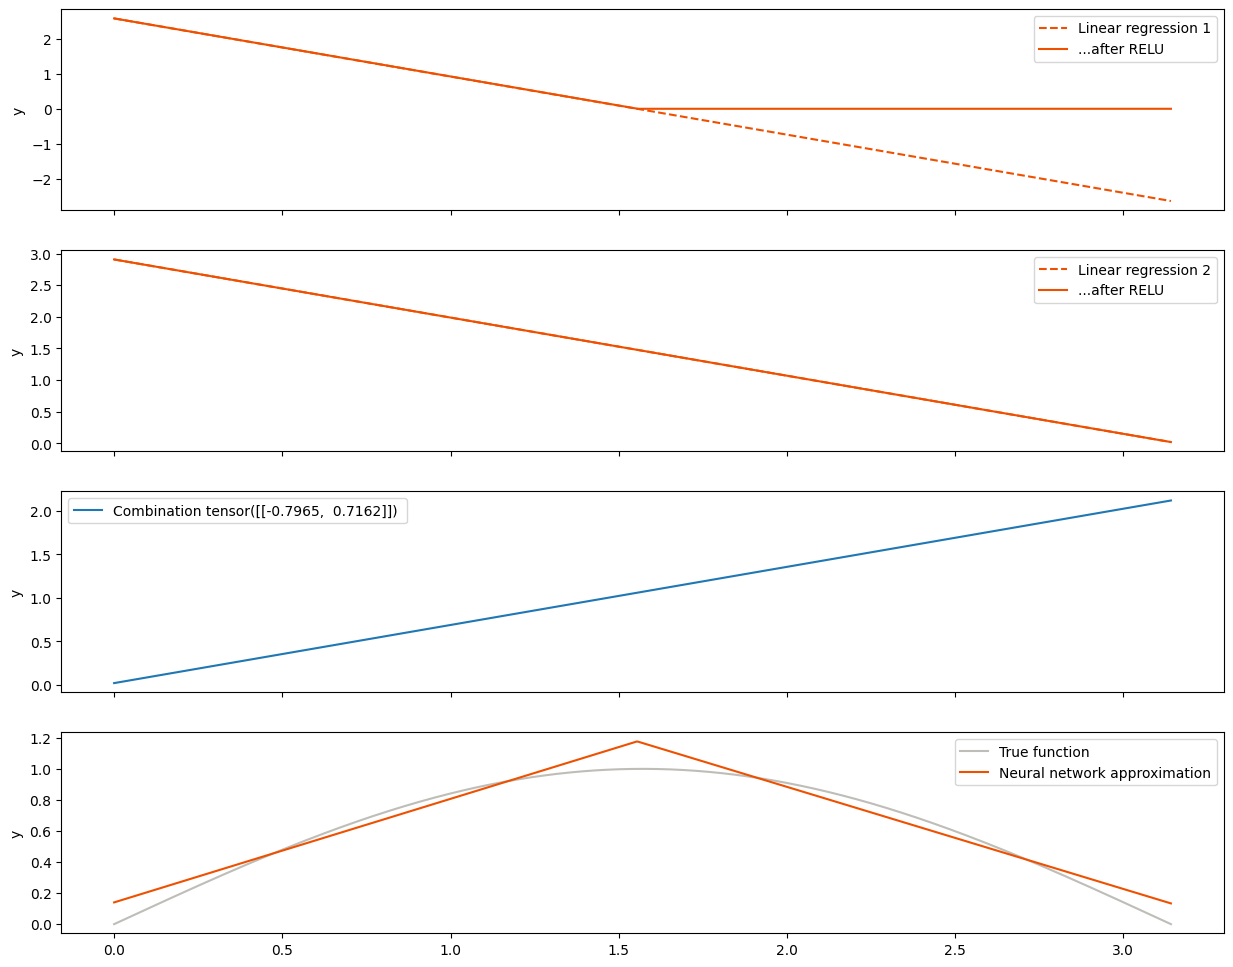

In [17]:
n_hidden = hidden_components.shape[1]
n_plots = n_hidden + 2
fig, ax = plt.subplots(n_plots, figsize=(15,3*n_plots), sharex=True)
ax[-1].plot(x, y, ls='-', color='#BEBDB8', label='True function')
ax[-1].plot(x, y_pred, ls='-', color="#ef5000", label='Neural network approximation')
ax[-1].set_ylabel('y')
ax[-1].legend()
for i in range(n_hidden):
    ax[i].plot(x, hidden_components[:, i], ls='--', color='#ef5000', label=f'Linear regression {i + 1}')
    ax[i].plot(x, torch.relu(hidden_components)[:, i], ls='-', color='#ef5000', label='...after RELU')


ax[n_hidden].plot(x, y_1, label=f'Combination {weights.data} ')
for i in range(n_plots):
    ax[i].legend()
    ax[i].set_ylabel('y')


# Universal approximation theorem

Epoch [100/5000], Loss: 0.25323519
Epoch [200/5000], Loss: 0.11127643
Epoch [300/5000], Loss: 0.08516981
Epoch [400/5000], Loss: 0.06967327
Epoch [500/5000], Loss: 0.05512018
Epoch [600/5000], Loss: 0.04465391
Epoch [700/5000], Loss: 0.03924565
Epoch [800/5000], Loss: 0.03594040
Epoch [900/5000], Loss: 0.03307423
Epoch [1000/5000], Loss: 0.02963979
Epoch [1100/5000], Loss: 0.02364532
Epoch [1200/5000], Loss: 0.01556811
Epoch [1300/5000], Loss: 0.00889952
Epoch [1400/5000], Loss: 0.00497559
Epoch [1500/5000], Loss: 0.00292005
Epoch [1600/5000], Loss: 0.00177775
Epoch [1700/5000], Loss: 0.00110408
Epoch [1800/5000], Loss: 0.00069983
Epoch [1900/5000], Loss: 0.00045350
Epoch [2000/5000], Loss: 0.00030100
Epoch [2100/5000], Loss: 0.00020499
Epoch [2200/5000], Loss: 0.00014354
Epoch [2300/5000], Loss: 0.00010303
Epoch [2400/5000], Loss: 0.00007762
Epoch [2500/5000], Loss: 0.00005753
Epoch [2600/5000], Loss: 0.00004473
Epoch [2700/5000], Loss: 0.00003546
Epoch [2800/5000], Loss: 0.00002884
E

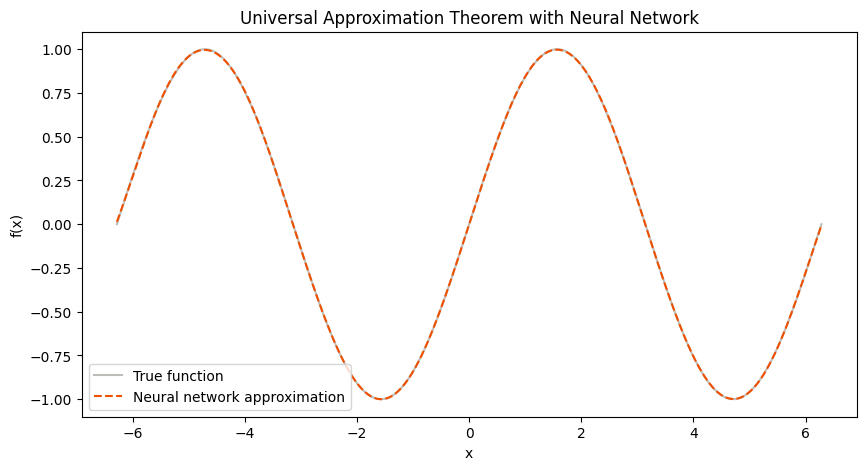

In [18]:
# Create data
x_train = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1)
y_train = np.sin(x_train)

# Convert data to torch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Define a feedforward neural network
class UniversalApproximator(nn.Module):
    def __init__(self):
        super(UniversalApproximator, self).__init__()
        self.hidden = nn.Linear(1, 20)  # Hidden layer with 20 neurons
        self.output = nn.Linear(20, 1)  # Output layer

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))  # Sigmoid activation function - makes illustration pretty fast
        x = self.output(x)  # No activation in the output layer
        return x

# Initialize the model, loss function, and optimizer
model = UniversalApproximator()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

# Make predictions after training
model.eval()
with torch.no_grad():
    predicted = model(x_train_tensor).numpy()

# Plot original sine function and the model's approximation
plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, label='True function', color='#BEBDB8', linestyle='-')
plt.plot(x_train, predicted, label='Neural network approximation', color='#ef5000', linestyle='--')
plt.title('Universal Approximation Theorem with Neural Network')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()